In [ ]:
# Borali, Beril
# 300036112
# Assignment 1
# CSI 5155

In [403]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree,  svm, neighbors, ensemble, metrics
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [404]:
# Import the dataset
df = pd.read_csv("drug_consumption.csv")

In [405]:
feature_set=["ID","Age","Gender","Education","Country","Ethnicity","Nscore","Escore","Oscore","Ascore","Cscore",
             "Impulsive","SS","Alcohol","Amphet","Amyl","Benzos","Caff","Cannabis","Choc","Coke","Crack",
             "Ecstasy","Heroin","Ketamine","Legalh","LSD","Meth","Mushrooms","Nicotine","Semer","VSA"]

drugs_set=feature_set[13:].copy()
#features
df.columns=feature_set

In [406]:
# labels
df_drugs=df[drugs_set].copy()
df_people=df.drop(drugs_set, axis=1)

In [407]:
# create labels
# 0 for "Non-User", 1 for "User" category/labels
# CL0 ... CL6
for drug in df_drugs:
    for i in df_drugs[drug].index:
        if  (df_drugs[drug][i]=="CL0" or df_drugs[drug][i]=="CL1"):
            df_drugs[drug][i]=0  # "Non-User"
        else:
            df_drugs[drug][i]=1  # "User"

In [408]:
people_train,people_test, drugs_train, drugs_test=train_test_split(df_people, df_drugs, test_size=0.33)
drugs_subset=["Alcohol","Amphet","Mushrooms","Cannabis","Coke","LSD"]

In [409]:
drug_models=[]
drug_predictions=[]
#creates and trains 6 DecisionTreeClassifier models for each of the 6 selected drugs
d_models=[]
d_preds=[]
# 6 learning tasks for 6 drugs in total
for drug in drugs_subset:
    model=tree.DecisionTreeClassifier()
    model.fit(people_train, drugs_train[drug].astype('int'))
    # predicting with the test set
    drug_pred = model.predict(people_test)
    d_models.append(model)
    d_preds.append(drug_pred)
    
drug_models.append(d_models)
drug_predictions.append(d_preds)

In [410]:
#creates and trains 6 RandomForestClassifier models for each of the 6 selected drugs

d_models=[]
d_preds=[]    
# 6 learning tasks for 6 drugs in total
for drug in drugs_subset:
    model=ensemble.RandomForestClassifier()
    model.fit(people_train, drugs_train[drug].astype('int'))
    drug_pred = model.predict(people_test)
    d_models.append(model)
    d_preds.append(drug_pred)
    
drug_models.append(d_models)
drug_predictions.append(d_preds)

mdrugs=len(drugs_subset)
nmodels=len(drug_models)

In [411]:
#creates and trains 6 SupportVectorMachine models for each of the 6 selected drugs

d_models=[]
d_preds=[]
# 6 learning tasks for 6 drugs in total
for drug in drugs_subset:
    model=svm.SVC(probability=True) # probability must be True to calculate the probability scores
    model.fit(people_train, drugs_train[drug].astype('int'))
    drug_pred = model.predict(people_test)
    d_models.append(model)
    d_preds.append(drug_pred)
    
drug_models.append(d_models)
drug_predictions.append(d_preds)

In [412]:
#creates and trains 6 KNeighborsClassifier models for each of the 6 selected drugs

d_models=[]
d_preds=[]
# 6 learning tasks for 6 drugs in total
for drug in drugs_subset:
    model=neighbors.KNeighborsClassifier()
    model.fit(people_train, drugs_train[drug].astype('int'))
    drug_pred = model.predict(people_test)
    d_models.append(model)
    d_preds.append(drug_pred)
    
drug_models.append(d_models)
drug_predictions.append(d_preds)

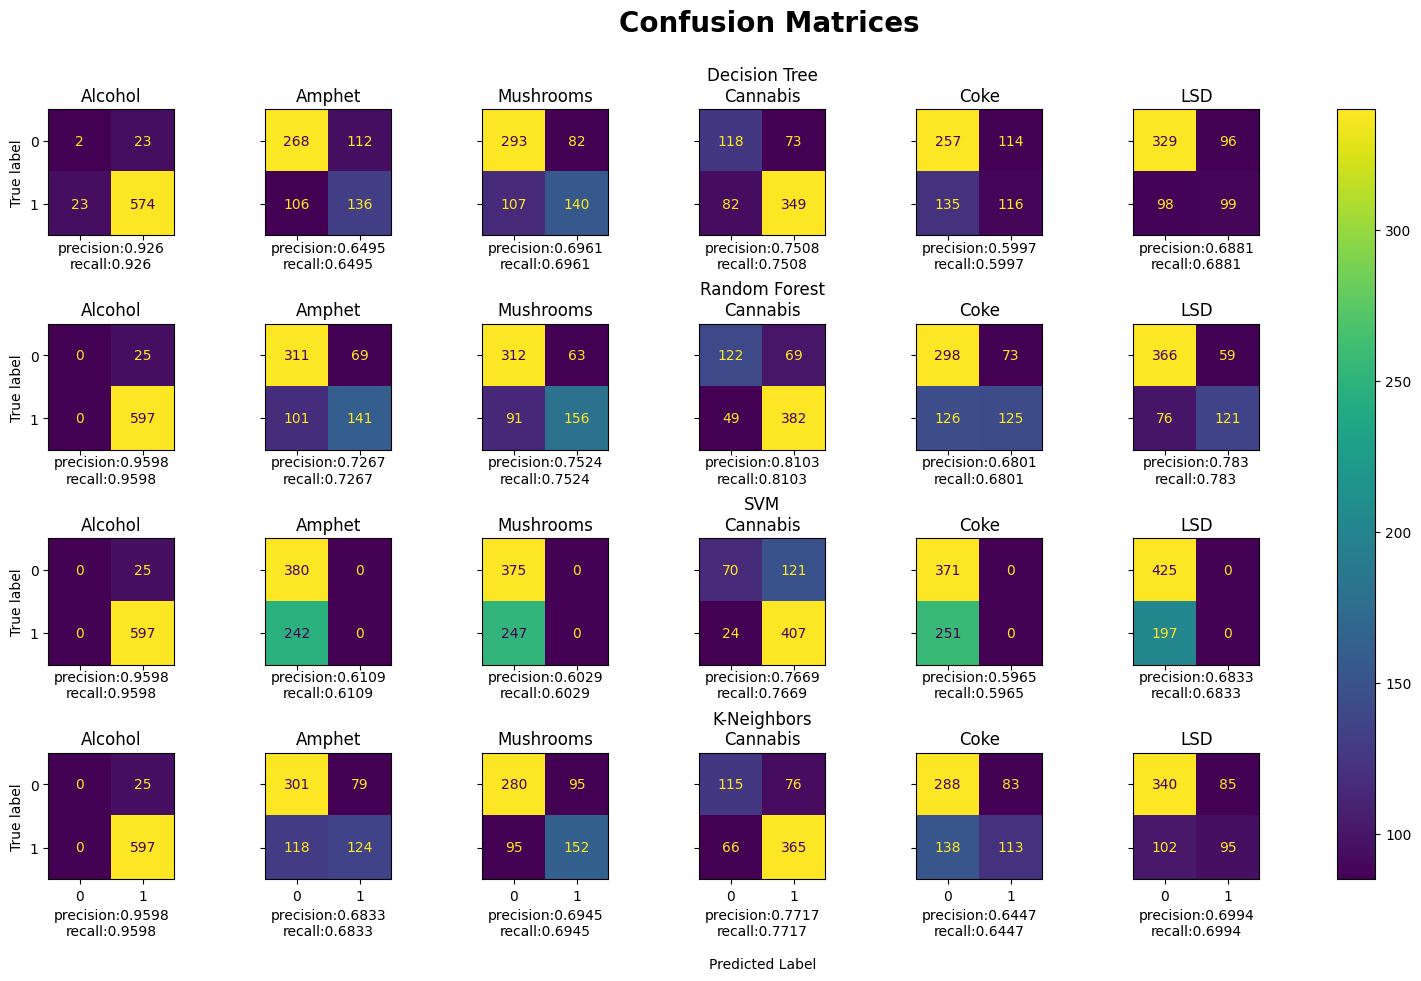

In [459]:
# plot confusion matrices

mdrugs=len(drugs_subset)
nmodels=len(drug_models)
model_names=["Decision Tree","Random Forest", "SVM", "K-Neighbors"]

fig, axs = plt.subplots(nmodels, mdrugs, figsize=(20,10),sharex='col',sharey='row')

# for all the 4 types of models:
for j in range(0,nmodels):
    for i in range(0,mdrugs):
        # create confusion matrix
        cm=metrics.confusion_matrix(drugs_test[drugs_subset[i]].values.tolist(),drug_predictions[j][i])
        #display and plot the confusion matrix
        disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=drug_models[j][i].classes_) # model.classes_=[0,1] 
        disp.plot(ax=axs[j][i])
        disp.im_.colorbar.remove()
        if i==3:
            disp.ax_.set_title('\n\n'+str(model_names[j])+'\n'+str(drugs_subset[i]))
        else:
            disp.ax_.set_title(drugs_subset[i])
        
        precision_recall_micro=metrics.precision_recall_fscore_support(drugs_test[drugs_subset[i]].values.tolist(), drug_predictions[j][i], average='micro')
        precision_recall_micro=precision_recall_micro[:2]
#         print(drugs_subset[i], model_names[j], "precision:",precision_recall_micro[0], "recall:",precision_recall_micro[1])
        
        disp.ax_.set_xlabel('precision:'+str(round(precision_recall_micro[0],4))+ '\nrecall:'+str(round(precision_recall_micro[1],4))+'\n')
        
        if j==(nmodels-1) and i==3:
            disp.ax_.set_xlabel('precision:'+str(round(precision_recall_micro[0],4))+ '\nrecall:'+str(round(precision_recall_micro[1],4))+'\n\nPredicted Label')
            
        disp.ax_.set_ylabel('')
        if i==0:
            disp.ax_.set_ylabel('True label')
            
        
            
fig.suptitle('Confusion Matrices',fontweight ="bold", fontsize=20)
plt.subplots_adjust(wspace=0.40, hspace=0.7)
fig.colorbar(disp.im_, ax=axs)
plt.show()


Text(0.5, 0.98, 'ROC Curves and Area Under the Curve per Drug')

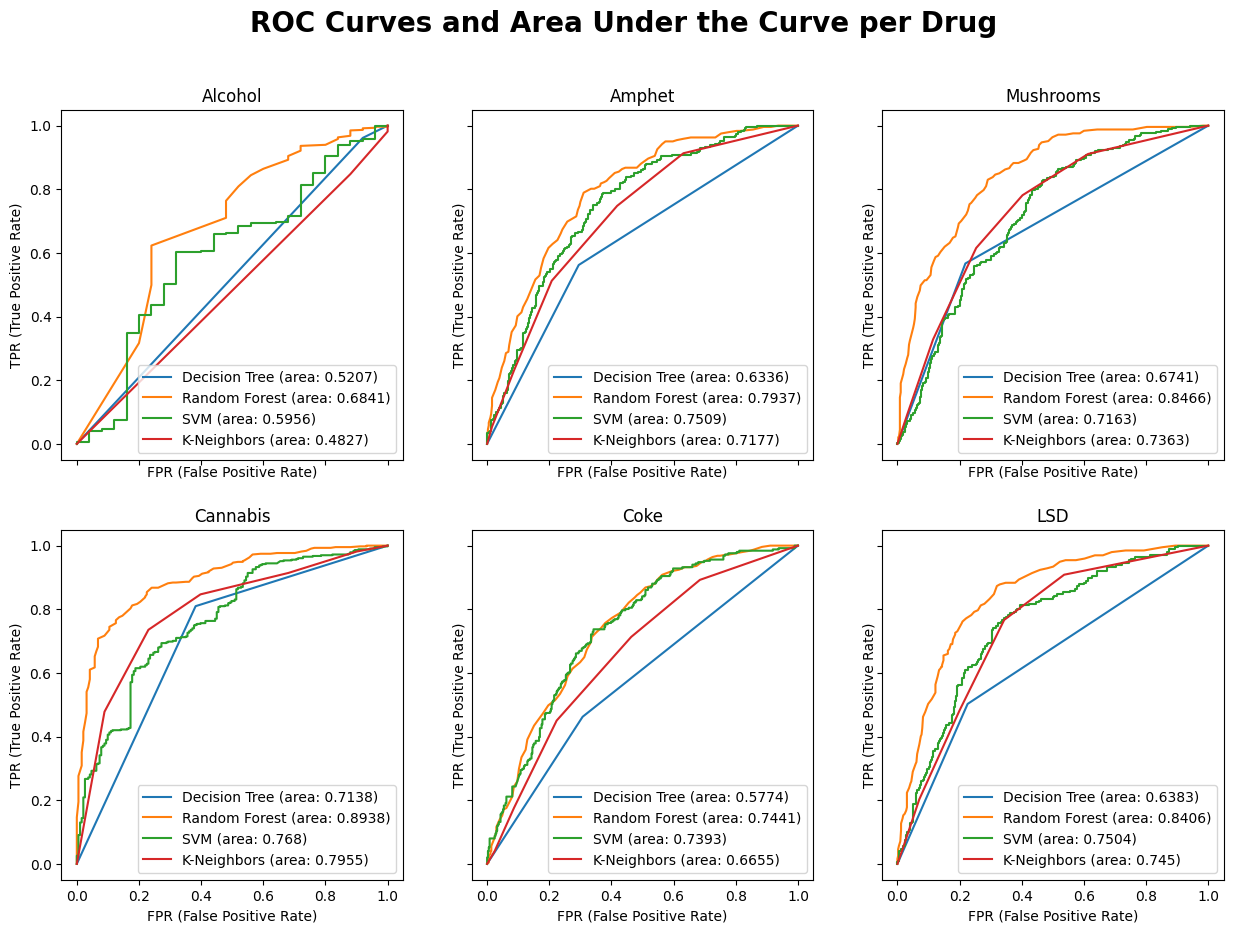

In [416]:
# plot ROC curves

fig, axs = plt.subplots(2,3, figsize=(15,10),sharex='col',sharey='row')

for i in range(0,mdrugs):
    for j in range(0,nmodels):
        #  probability of the class with the greater label
        drug_pred_scores = drug_models[j][i].predict_proba(people_test)[:,1]
        # false positive rate, true positive rate (and threshold "-" value but we don't use it here)
        fpr, tpr, _ = metrics.roc_curve(drugs_test[drugs_subset[i]].values.tolist(), drug_pred_scores)
        # area under the ROC curve
        auc=metrics.roc_auc_score(drugs_test[drugs_subset[i]].values.tolist(), drug_pred_scores)
#         print("For "+str(drugs_subset[i])+", "+str(model_names[j])+" area: " + str(auc))  
        
        c=i%3
        r=0
        if i>2:
            r=1
        axs[r,i%3].set_xlabel("FPR (False Positive Rate)")
        axs[r,i%3].set_ylabel("TPR (True Positive Rate)")
        axs[r,i%3].plot(fpr,tpr,label=str(model_names[j])+" (area: " + str(round(auc,4))+")")
        axs[r,i%3].set_title(drugs_subset[i])
        axs[r,i%3].legend()
        
fig.suptitle('ROC Curves and Area Under the Curve per Drug',fontweight ="bold", fontsize=20)